In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

jax.config.update("jax_enable_x64", True)

from parsmooth import MVNStandard
from parsmooth import FunctionalModel
from parsmooth.sequential._filtering import filtering
from parsmooth.linearization import extended, extended_hessian
from scipy.linalg import cho_solve
from parsmooth.sequential._filtering_Newton import _pseudo_update
from parsmooth.sequential._filtering_Newton import filtering as newton_filtering

In [2]:
def dynamic_model(xk):
    return jnp.tanh(xk)
def measurement_model(xk):
    return jnp.sin(xk)

In [3]:
# Get data
T = 100 # steps

xs = np.zeros((T, 1)) # NB: state starts from 0 to T+1
ys = np.zeros((T, 1))

np.random.seed(1)
sigma = 0.1

x0 = np.random.normal(loc=0, scale=1) # initial state
x = x0
xs[0] = x

for k in range(T):
    q = np.random.normal(loc=0, scale=sigma)
    r = np.random.normal(loc=0, scale=sigma)

    x = dynamic_model(x) + q
    y = measurement_model(x) + r

    xs[k] = x
    ys[k] = y

2023-01-16 17:26:49.914233: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-16 17:26:50.033762: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-16 17:26:50.196288: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

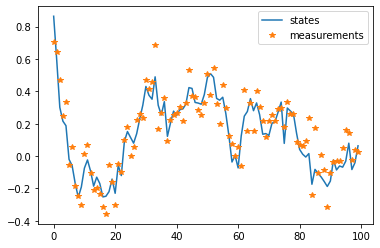

In [4]:
plt.figure()
plt.plot(xs)
plt.plot(ys, '*')
plt.legend(['states', 'measurements']);

In [5]:
Q = jnp.array([[sigma**2]])
R = jnp.array([[sigma**2]])

transition_model = FunctionalModel(partial(dynamic_model), MVNStandard(jnp.zeros((1,)), Q))
observation_model = FunctionalModel(partial(measurement_model), MVNStandard(jnp.zeros((1,)), R))

In [6]:
# Filtering
m0 = jnp.array([-1.])
P0 = jnp.eye(1)
init = MVNStandard(m0, P0)

xf = filtering(ys, init, transition_model, observation_model, extended, None)


2023-01-16 17:26:50.452448: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-16 17:26:50.523544: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-16 17:26:50.601138: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

In [7]:
filtered_states_newton = newton_filtering(ys, init, transition_model, observation_model, extended_hessian, None)

2023-01-16 17:26:51.891325: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-16 17:26:51.893264: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-16 17:26:51.893318: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

2023-01-16 17:26:52.061840: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-16 17:26:52.132745: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-16 17:26:52.205130: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

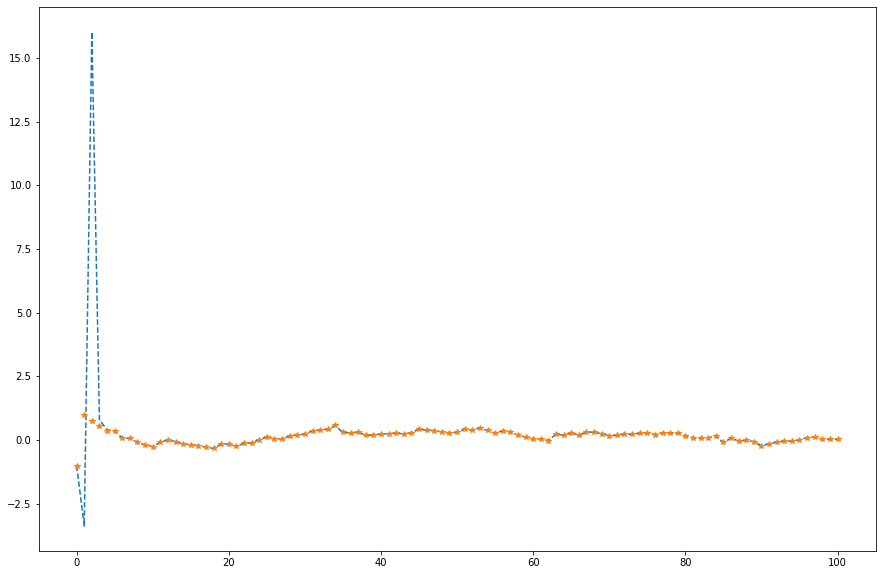

In [8]:
plt.figure(figsize=(15,10))
plt.plot(filtered_states_newton.mean, "--")
plt.plot(xf.mean, "*")